# 1. ShopAssist AI Bot - Ravi Divecha

## 1.1 Project Background

In today's digital age, online shopping has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed ShopAssist AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery.


## 1.2 Problem Statement

Given a dataset containing information about laptops (product names, specifications, descriptions, etc.), build a chatbot that parses the dataset and provides accurate laptop recommendations based on user requirements.


##1.3 System Design Work Flow

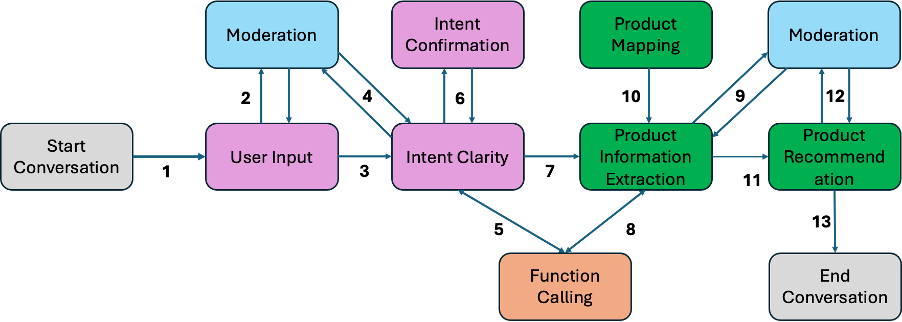

## 1.4 Instructions to run the notebook

1.	Install openAI 0.28
2.	Change your OS directory. Currently set to
os.chdir('/content/drive/MyDrive/upgrad/GenAI_Course_Master/Course_1_ShopAssistAI/Week_2/Session_1/')
3.	Sample string user input.
"work laptop with budget upto 300000 with high GPU, high multi tasking, low portability and good screen resolution and high processing speed"

In [1]:
#Install openai
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.6 MB/s eta 0:00:00


In [2]:
!pip show openai

Name: openai
Version: 0.28.0
Summary: Python client library for the OpenAI API
Home-page: https://github.com/openai/openai-python
Author: OpenAI
Author-email: support@openai.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, requests, tqdm
Required-by: 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/upgrad/GenAI_Course_Master/Course_1_ShopAssistAI/Week_2/Session_1/')
!ls

Intro_to_function_calling_SKH.ipynb	    ShopAssistAI_Demonstration_V1.ipynb
laptop_data.csv				    ShopAssistAI_Demonstration_v2_Stage1.ipynb
OpenAI_API_Key_Cisco.txt		    system_design.png
OpenAI_API_Key.txt			    tata_motors_transcript_sample.txt
RaviDivecha_Final_Project_ShopAssist.ipynb  updated_laptop.csv
ShopAssist_AI_2_0_Sample_Solution.ipynb     updated_laptop_final.csv
ShopAssistAI_Demonstration_Complete.ipynb


In [5]:
## Import the necessary libraries for building the project
import os,json,ast
import openai
import pandas as pd
from IPython.display import display, HTML
# Set the display width to control the output width
pd.set_option('display.width', 100)

## Add your OPENAI API KEY
##openai.api_key = "OPENAI_API_KEY"

filepath = '/content/drive/MyDrive/upgrad/GenAI_Course_Master/Course_1_ShopAssistAI/Week_2/Session_1/'
# read the OpenAI API key
with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())
#openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

#2. Function Descriptions

## 2.1 Function Calling

In [6]:
## Function Description for the Function Calling API

function_descriptions = [
            {
                "name": "compare_laptops_with_user",
                "description": "Get the top 3 laptops from the catalogue, that best matches what the user is asking based on 'GPU intensity','Display quality','Portability','Multitasking','Processing speed' & 'Budget",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "gpu intensity": {
                            "type": "string",
                            "description": "The requirement of the user in GPU capacity classfied as low, medium or high" ,
                        },
                        "display quality": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's Display Quality & capacity classfied as low, medium or high" ,
                        },
                        "portability": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's portability classfied as low, medium or high" ,
                        },
                        "multitasking": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's Multitasking classfied as low, medium or high" ,
                        },
                        "processing speed": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's Processing speed classfied as low, medium or high" ,
                        },
                        "budget": {
                            "type": "integer",
                            "description": "The maximum budget of the user" ,
                        },

                    },
                    "required": ["GPU intensity","Display quality","Portability","Multitasking","Processing speed","Budget"],
                },
            },
        {
                'name': 'extract_school_info',
                'description': 'Get the school information from the body of the input text',
                'parameters': {
                    'type': 'object',
                    'properties': {
                        'name': {
                            'type': 'string',
                            'description': 'Name of the school.'
                        },
                        'ranking': {
                            'type': 'integer',
                            'description': 'QS world ranking of the school.'
                        },
                        'country': {
                            'type': 'string',
                            'description': 'Country of the school.'
                        },
                        'no_of_students': {
                            'type': 'integer',
                            'description': 'Number of students enrolled in the school.'
                        }
                  }
              }
          }
        ]

## 2.2 Intent Confirmation

intent_confirmation_layer(): This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget


In [7]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"

    allowed_values = {'low','medium','high'}

    prompt = f"""
    You are a senior evaluator who has an eye for detail.The input text will contain a user requirement captured through 6 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'GPU intensity': 'values',
    'Display quality':'values',
    'Portability':'values',
    'Multitasking':'values',
    'Processing speed':'values',
    'Budget':'number'
    }}
    The values for the keys should only be from the allowed values: {allowed_values}.
    The 'Budget' key can take only a numerical value.
    Next you need to evaluate if the keys have the the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    THought 3 - Think carefully before the answering.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]
    response = openai.ChatCompletion.create( # requires openai 0.28
 #   response = openai.chat.completions.create( ## original code openai >1
                                    model="gpt-3.5-turbo",
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

## 2.3 Initialize Conversation

initialize_conversation(): This initializes the variable conversation with the system message.

In [8]:
def initialize_conversation():
    delimiter = "####"

    system_message = f"""
    You are an intelligent laptop gadget expert and your goal is to find the best laptop
    for a user.
    You are trying to understand the user's requirement for these laptop's
    features: ('gpu intensity','display quality','portability','multitasking',
    'processing speed','budget')
    You need to ask relevant questions and understand the user need for each
    feature by analysing the user's responses.
    After understanding their requirements, you'll use a function call to suggest
    the top 3 laptops with their respective user match score.
    Recommend these laptops and answer any user's query about them.

    {delimiter} Here are certain guidelines that you need to follow:
    Don't ask questions about more than 2 features at a time.
    If the user's budget is less than says less than 25000 INR, please mention that there are no laptops in that range.
    Recommend the top3 laptops in the following format:
    Start with a brief summary of each laptop in the following format, in decreasing order of price of laptops:
    1. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    2. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    3. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    {delimiter}

    {delimiter}To find the top3 laptops, you need to have the following chain of thoughts:
    Thought 1: Ask one question to understand the user's profile and requirements. \n
    If their primary use for the laptop is unclear. Ask another question to comprehend their needs.
    Answer "Yes" or "No" to indicate if you understand the requirements. \n
    If yes, proceed to the next step. Otherwise, rephrase the question to capture their profile. \n

    Thought 2: Now, you are trying to understand the requirements for other features which you couldn't in the previous step.
    Ask questions to strengthen your understanding of the user's profile.
    Don't ask questions about more than 2 features at a time.
    Answer "Yes" or "No" to indicate if you understood all the needs of the features and are confident about the same.
    If yes, move to the next Thought. If no, ask question on the features whose needs you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the feature you want to understand the need for.{delimiter}
    {delimiter}

    {delimiter} Here is a sample conversation between the user and assistant:
    Assistant: "Hello! I'm here to help you find the perfect laptop that suits your needs. Could you please share your requirements?"
    User: "Hi, I am an editor."
    Assistant: "Great! As an editor, you likely require a laptop that can handle demanding tasks. Hence, the laptop should have high multitasking capability. You would also need a high end display for better visuals and editing. May I know what kind of work do you primarily focus on? Are you more involved in video editing, photo editing, or both? Understanding the specific type of editing work will help me tailor my recommendations accordingly. Let me know if my understanding is correct until now."
    User: "I primarily work with After Effects."
    Assistant: "Thank you for providing that information. Working with After Effects involves working with graphics, animations, and rendering, which will require high GPU. Do you work with high-resolution media files, such as 4K videos or RAW photos? Understanding your file sizes will help determine the storage capacity and processing power needed."
    User: "Yes, sometimes I work with 4K videos as well."
    Assistant: "Thank you for the information. Processing 4K vidoes will require a good processor and high GPU. I think we have already determined earlier that you need a high GPU. To ensure I have a complete understanding of your needs, I have one more question: Are you frequently on the go and require a laptop that is lightweight and easy to carry, or do you primarily work from a stationary location?"
    User: "Yes, sometimes I travel but do not carry my laptop."
    Assistant:"Could you kindly let me know your budget for the laptop? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 1.5lakh inr"
    {delimiter}


    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    return conversation

## 2.4 API chat completion Call

get_chat_completions(): This takes the ongoing conversation as the input and returns the response by the assistant

In [10]:
def get_chat_model_completions(messages):
    response = openai.ChatCompletion.create( # requires openai 0.28
#    response = openai.chat.completions.create(
        model="gpt-4-0613",
#        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
        max_tokens = 500,

        functions=function_descriptions,
        function_call="auto",
    )
    return response.choices[0].message ## original code
#    return response.choices[0].message['content'] ## incorrect code

## 2.5 Compare laptop with user

dictionary_present(): This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.

compare_laptops_with_user(): This function compares the user's profile with the different laptops and come back with the top 3 recommendations.

recommendation_validation(): This function verifies that the laptop recommendations are good enough, has score greater than 2, and matches the user's requirements


In [11]:
import pandas as pd
import ast
import re

def extract_dictionary_from_string(string):
    regex_pattern = r"\{[^{}]+\}"

    dictionary_matches = re.findall(regex_pattern, string)

    # Extract the first dictionary match and convert it to lowercase
    if dictionary_matches:
        dictionary_string = dictionary_matches[0]
        dictionary_string = dictionary_string.lower()

        # Convert the dictionary string to a dictionary object using ast.literal_eval()
        dictionary = ast.literal_eval(dictionary_string)
    return dictionary

def compare_laptops_with_user(user_req_string):

  budget = user_req_string.get('budget', '0')

#  laptop_df= pd.read_csv('laptop_data.csv'). ## original code
  laptop_df= pd.read_csv('updated_laptop_final.csv') ## new code

  filtered_laptops = laptop_df.copy()
  filtered_laptops['Price'] = filtered_laptops['Price'].str.replace(',','').astype(int)
  filtered_laptops = filtered_laptops[filtered_laptops['Price'] <= budget].copy()

  mappings = {
          'low': 0,
          'medium': 1,
          'high': 2
      }
  # Create 'Score' column in the DataFrame and initialize to 0
  filtered_laptops['Score'] = 0
  for index, row in filtered_laptops.iterrows():
      user_product_match_str = row['laptop_feature']
      laptop_values = extract_dictionary_from_string(user_product_match_str)
      score = 0

      for key, user_value in user_req_string.items():
        if key.lower() == 'budget':
            continue  # Skip budget comparison
        laptop_value = laptop_values.get(key, None)
        laptop_mapping = mappings.get(laptop_value.lower(), -1)
        user_mapping = mappings.get(user_value.lower(), -1)
        if laptop_mapping >= user_mapping:
          ### If the laptop value is greater than or equal to the user value the score is incremented by 1
          score += 1

      filtered_laptops.loc[index, 'Score'] = score

  # Sort the laptops by score in descending order and return the top 5 products
  top_laptops = filtered_laptops.drop('laptop_feature', axis=1)
  top_laptops = top_laptops.sort_values('Score', ascending=False).head(3)


  return top_laptops.to_json(orient='records')

def recommendation_validation(laptop_recommendation):

    data = json.loads(laptop_recommendation)
    data1 = []
    for i in range(len(data)):
      if data[i]['Score'] > 2:
        data1.append(data[i])

    return json.dumps(data1)

## 2.6 Moderation Check

moderation_check(): This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.

In [12]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.

#    response = openai.moderations.create(input=user_input) ## from upgrade
    response = openai.Moderation.create(input=user_input) ## from stack overflow for openai <1

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

## 2.7 Dictionary Present

In [13]:
from openai import ChatCompletion

def dictionary_present(response):
    delimiter = "####"

    user_req = {'GPU intensity': 'high',
                'Display quality': 'high',
                'Portability': 'medium',
                'Multitasking': 'high',
                'Processing speed': 'high',
                'Budget': '200000'}

    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
            The output should match the format as {user_req}.

            {delimiter}
            Make sure that the value of budget is also present in the user input. ###
            The output should contain the exact keys and values as present in the input.
            Ensure the keys and values are in the given format:
            {{
            'GPU intensity': 'low/medium/high ',
            'Display quality':'low/medium/high',
            'Portability':'low/medium/high',
            'Multitasking':'low/medium/high',
            'Processing speed':'low/medium/high',
            'Budget':'numerical value'
            }}
            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1: - GPU intensity: low - Display quality: high - Portability: low - Multitasking: high - Processing speed: medium - Budget: 50,000 INR
            output 1: {{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': '50000'}}

            input 2: {{'GPU intensity':     'low', 'Display quality':     'low', 'Portability':    'medium', 'Multitasking': 'medium', 'Processing speed': 'low', 'Budget': '90,000'}}
            output 2: {{'GPU intensity': 'low', 'Display quality': 'low', 'Portability': 'medium', 'Multitasking': 'medium', 'Processing speed': 'low', 'Budget': '90000'}}

            input 3: Here is your user profile 'GPU intensity': 'high','Display quality': 'high','Portability': 'medium','Multitasking': 'high','Processing speed': 'high','Budget': '200000 INR'
            output 3: {{'GPU intensity': 'high','Display quality': 'high','Portability': 'medium','Multitasking': 'high','Processing speed': 'high','Budget': '200000'}}
            {delimiter}
            """
    messages = [{"role": "system", "content":prompt },
                {"role": "user", "content":f"""Here is the user input: {response}""" }]
#    response = openai.ChatCompletion.create( # requires openai 0.28
#    confirmation = get_chat_completions(messages, json_format = True) ## original code
    confirmation = ChatCompletion(messages, json_format = True) ## original code
    return confirmation

##2.8 Initialize Conversation Recommendation

initialize_conv_reco(): Initializes the recommendations conversation

In [15]:
def initialize_conv_reco(products):
#    print("Products:", products)
    system_message = f"""
    You are an intelligent laptop gadget expert and you are tasked with the objective to \
    solve the user queries about any product from the catalogue in the user message \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each laptop in the following format, in decreasing order of price of laptops:
    1. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    2. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    # conversation_final = conversation[0]['content']
    return conversation

#3. Dialogue Management System

Integration of all functions to create ShopAssist AI Bot

In [25]:
def dialogue_mgmt_system():

    conversation = initialize_conversation()
    introduction = get_chat_model_completions(conversation)["content"]
    display(introduction)
    user_input = ""
    top_3_laptops = None

    while(user_input != "exit"):
        user_input = input("")
        moderation = moderation_check(user_input)

        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_laptops is None:

            conversation.append({"role": "user", "content": user_input})
            response_assistant = get_chat_model_completions(conversation)

            if response_assistant.content is not None:
                moderation = moderation_check(response_assistant.content)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break
            else:
                moderation = moderation_check(response_assistant.function_call.arguments)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

        ## intent confirmation layer start
            confirmation = intent_confirmation_layer(response_assistant)

            print("Intent Confirmation Yes/No:",confirmation.get('result'))

            if "No" in confirmation.get('result'):
                        conversation.append({"role": "assistant", "content": str(response_assistant)})
                        print("\n" + str(response_assistant.content) + "\n")
            else:
                        print("\n" + str(response_assistant) + "\n")
#                        print('\n' + "Variables extracted!" + '\n')
                ## dictionary call start
                        response = dictionary_present(response_assistant)
                ## dictionary call end

                        if response_assistant.get("function_call"):
                            print("\nThank you for providing all the information. Kindly wait, while I fetch the products\n")
                            # Extract top3 laptops by calling the external function

                            function_name = response_assistant["function_call"]["name"]
                            function_args = json.loads(response_assistant["function_call"]["arguments"])
                            top_3_laptops = compare_laptops_with_user(function_args)
                            function_response = recommendation_validation(top_3_laptops)

                            if len(function_response) == 0:
                                print("Sorry, we do not have laptops that match your requirements. Connecting you to a human expert.")
                                break
                            # Send the info on the function call and function response to GPT
                            conversation.append(response_assistant)
                            conversation.append(
                                {
                                    "role": "function",
                                    "name": function_name,
                                    "content": function_response,
                                }
                            )
                            recommendation = get_chat_model_completions(conversation)

                            if recommendation.content is not None:
                                moderation = moderation_check(recommendation.content)
                                if moderation == 'Flagged':
                                    display("Sorry, this message has been flagged. Please restart your conversation.")
                                    break
                            else:
                                moderation = moderation_check(recommendation.function_call.arguments)
                                if moderation == 'Flagged':
                                    display("Sorry, this message has been flagged. Please restart your conversation.")
                                    break

                            conversation.append({"role": "assistant", "content": recommendation["content"]})
                            print("\n" +recommendation["content"] + "\n")

            ## validation comments start
                            validated_reco = recommendation_validation(top_3_laptops)

                            conversation_reco = initialize_conv_reco(validated_reco)

                            conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})

                            recommendation = get_chat_model_completions(conversation_reco)


                            if recommendation.content is not None:
                                    moderation = moderation_check(recommendation.content)
                                    if moderation == 'Flagged':
                                        display("Sorry, this message has been flagged. Please restart your conversation.")
                                        break
                            else:
                                    moderation = moderation_check(recommendation.function_call.arguments)
                                    if moderation == 'Flagged':
                                        display("Sorry, this message has been flagged. Please restart your conversation.")
                                        break


                            conversation_reco.append({"role": "assistant", "content": recommendation["content"]})



        ## validation comments end

                        else:
                          conversation.append({"role": "assistant", "content": response_assistant["content"]})
                          print("I have not hit function calling yet because all information is not present")
                          print("\n" +  response_assistant["content"] + "\n")


        else:

            if user_input == "exit":
                break
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_model_completions(conversation_reco)

            if response_asst_reco.content is not None:
                    moderation = moderation_check(response_asst_reco.content)
                    if moderation == 'Flagged':
                        display("Sorry, this message has been flagged. Please restart your conversation.")
                        break
            else:
                    moderation = moderation_check(response_asst_reco.function_call.arguments)
                    if moderation == 'Flagged':
                        display("Sorry, this message has been flagged. Please restart your conversation.")
                        break

            print(response_asst_reco.content)
            conversation.append({"role": "assistant", "content": response_asst_reco})


In [27]:
dialogue_mgmt_system()

'Assistant: "Hello! I\'m here to help you find the perfect laptop that suits your needs. Could you please share your requirements?"'

i need a laptop for work which is portable
Intent Confirmation Yes/No: No

Sure, I can help with that. When you say work, could you please specify the nature of your work? Are you into graphic designing, coding, video editing, or any other specific field? This will help me understand the processing speed and GPU intensity you might require. Also, could you please specify your budget for the new laptop?

i am in graphics design
Intent Confirmation Yes/No: No

{
  "role": "assistant",
  "content": "Great! As a graphic designer, you would need a laptop with a high-quality display and a good GPU. Do you work with high-resolution designs or do you need a laptop that can handle multitasking efficiently? Also, could you please share your budget for the laptop?"
}

#work laptop with budget upto 300000 with high GPU, high multi tasking, low portability and good screen resolution and high processing speed
Intent Confirmation Yes/No: Yes

{
  "role": "assistant",
  "content": null,
  "function_ca

#4. End